# Experiment picker

Use the widget below to select experiments from `data/`. If an experiment contains configuration subfolders (for example `data/exp/<cfg>/001`) it will be treated as a multi-config experiment and a per-experiment config picker will be shown (including an "all" option). If the experiment has `001` directly under `data/exp/001` it will be treated as a single-run experiment and no config picker will be shown. Pick experiments, select configs (or `all`), then click **Load experiment**. The results will be printed and saved as `picker.last_loaded`.

> Tip: If the widgets do not show or importing `plothelpers2` raises an error, install the widget dependency with:
> ```bash
> pip install ipywidgets
> ```

In [1]:
# EXP picker
from pathlib import Path
import plothelpers2 as ph

# create and show the picker (data folder is relative to this notebook)
DATA_DIR = Path('data')
picker = ph.create_and_show_picker(DATA_DIR)

## Data Picker
once the experiment choosen choose which csv to load to get the data.

In [ ]:
# CSV picker per selected experiment/path
import os
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd


def create_csv_picker_for_loaded_paths(picker, data_dir=None):
    """For each path in `picker.last_loaded` (each either `data/exp` or `data/exp/cfg`),
    find the first folder named '1' (recursively) and list CSV files found there. Show a
    single RadioButtons widget per *experiment* (top-level directory under `data/`) for
    choosing which CSV to load for that experiment.

    The returned loader builds `loaded_data` accessible in the notebook as a nested dict:
      loaded_data[experiment_key][run_name][robot_int] -> pandas.DataFrame

    `experiment_key` is usually the top-level experiment name under `data` (e.g., 'ProofOfWork').
    If a loaded experiment has multiple configuration subfolders (e.g., `ProofOfWork/cfg1`),
    the loader will store runs under keys like `ProofOfWork/cfg1` while the UI still shows
    only one radio button per top-level experiment. This means the radio selection applies
    to all configs of that experiment.
    """
    if data_dir is None:
        data_dir = getattr(picker, 'data_dir', Path('data'))
    data_dir = Path(data_dir)

    if not getattr(picker, 'last_loaded', None):
        print("No experiments loaded — run the picker and click Load experiment first")
        return lambda: {}

    # Group paths by top-level experiment name (first component relative to data_dir)
    exp_map = {}  # experiment_key -> {'base_paths': dict(base_path_key->Path), 'probe_dirs': set()}

    for entry in picker.last_loaded:
        for pstr in entry.get('paths', []):
            base_path = Path(pstr)
            # Determine experiment key as the first part relative to data_dir when possible
            try:
                rel = base_path.relative_to(data_dir)
                exp_key = str(rel.parts[0])
                # If base_path includes a second part, treat it as a specific config: exp/cfg
                if len(rel.parts) >= 2:
                    base_path_key = f"{rel.parts[0]}/{rel.parts[1]}"
                else:
                    base_path_key = exp_key
            except Exception:
                # Fallback: use the parent folder name if it seems to represent the experiment
                if base_path.parent and base_path.parent != base_path:
                    exp_key = base_path.parent.name
                    base_path_key = f"{exp_key}/{base_path.name}" if base_path.name != exp_key else exp_key
                else:
                    exp_key = base_path.name
                    base_path_key = exp_key

            info = exp_map.setdefault(exp_key, {'base_paths': {}, 'probe_dirs': set()})
            # store base_path keyed by either "exp" or "exp/cfg" so we can later group runs per config
            info['base_paths'][base_path_key] = base_path

            # Find the first folder named '1' under this base_path (used to probe CSVs)
            probe_dir = None
            for root, dirs, files in os.walk(base_path):
                if '1' in dirs:
                    probe_dir = Path(root) / '1'
                    break

            if probe_dir and probe_dir.exists():
                info['probe_dirs'].add(probe_dir)

    radio_map = {}  # exp_key -> (RadioButtons, base_paths_dict, probe_dirs_list)
    widgets_list = []

    for exp_key, info in sorted(exp_map.items()):
        probe_dirs = info['probe_dirs']
        base_paths_dict = info['base_paths']

        if not probe_dirs:
            widgets_list.append(widgets.HTML(f"<b>{exp_key}</b>: no '1' folder found to probe CSVs"))
            continue

        # Collect all csv stems across probe dirs for this experiment
        csv_stems = set()
        for probe_dir in probe_dirs:
            for f in probe_dir.iterdir():
                if f.suffix.lower() == '.csv':
                    csv_stems.add(f.stem)

        if not csv_stems:
            widgets_list.append(widgets.HTML(f"<b>{exp_key}</b>: no CSV files found in {list(probe_dirs)[0]}"))
            continue

        options = sorted(csv_stems)
        rb = widgets.RadioButtons(options=options, description='', layout=widgets.Layout(width='auto'))
        rb.value = options[0]
        radio_map[exp_key] = (rb, base_paths_dict, sorted(probe_dirs))
        widgets_list.append(widgets.HBox([widgets.Label(f"{exp_key}:", layout=widgets.Layout(width='28%')), rb]))

    container = widgets.VBox(widgets_list)
    display(container)

    out = widgets.Output()

    def _load_data(_):
        out.clear_output()
        with out:
            loaded = {}
            # Record the chosen csv basename per experiment so other helpers can know which was chosen
            selected_csv_map = {}

            for exp_key, (rb, base_paths_dict, probe_dirs) in radio_map.items():
                sel = rb.value
                if not sel:
                    print(f"{exp_key}: no selection, skipped")
                    continue

                selected_csv_map[exp_key] = sel

                # Collect runs across all base paths belonging to this experiment. Each base_path
                # may be either the experiment root (key==exp_key) or a specific config (key=="exp/cfg").
                runs_info = []  # list of (base_path_key, run_path)
                for base_path_key, base_path in base_paths_dict.items():
                    runs = [d for d in base_path.iterdir() if d.is_dir() and d.name.isdigit()]
                    for r in runs:
                        runs_info.append((base_path_key, r))

                # Deduplicate runs by full path and sort by name
                unique_runs = sorted({r for _, r in runs_info}, key=lambda p: p.name)
                if not unique_runs:
                    print(f"{exp_key}: no run directories found under {', '.join(str(p) for p in base_paths_dict.values())}")
                    continue

                # Build an index from run Path -> base_path_key(s) so we can store runs under the appropriate
                # experiment/config key. A run may appear under multiple base_paths (unlikely) but we map to all.
                run_to_keys = {}
                for base_path_key, run in runs_info:
                    run_to_keys.setdefault(run, set()).add(base_path_key)

                for run, keys in sorted(run_to_keys.items(), key=lambda kv: kv[0].name):
                    for base_key in sorted(keys):
                        run_dict = loaded.setdefault(base_key, {}).setdefault(run.name, {})
                        # robot dirs inside run — numeric names starting at 1; exclude '0'
                        robots = sorted([d for d in run.iterdir() if d.is_dir() and d.name.isdigit() and int(d.name) != 0], key=lambda p: int(p.name))
                        if not robots:
                            print(f"{base_key}/{run.name}: no robot directories found")
                            continue

                        for robot in robots:
                            robot_key = int(robot.name)
                            csv_path = robot / (sel + '.csv')
                            if csv_path.exists():
                                try:
                                    df = pd.read_csv(csv_path)
                                    # Store the DataFrame directly (no csv_basename key level)
                                    run_dict[robot_key] = df
                                except Exception as e:
                                    print(f"Failed loading {csv_path}: {e}")
                            else:
                                print(f"CSV not found for {base_key}/{run.name}/{robot.name}: expected {csv_path}")

            # Save global variables
            globals()['loaded_data'] = loaded
            globals()['selected_csv_map'] = selected_csv_map
            print("Loading complete. `loaded_data` is available with structure:")
            print("loaded_data[experiment_key_or_experiment/config][run_name][robot_int] -> pandas.DataFrame")

    btn = widgets.Button(description='Load data')
    btn.on_click(_load_data)
    display(btn, out)

    def get_selections():
        # Return a representative csv path per experiment (first probe_dir is used)
        return {exp_key: str(sorted(probe_dirs)[0] / (rb.value + '.csv')) if rb.value and probe_dirs else None for exp_key, (rb, _, probe_dirs) in radio_map.items()}

    return get_selections

get_selections = create_csv_picker_for_loaded_paths(picker, DATA_DIR)


Button(description='Load data', style=ButtonStyle())

Output()

In [8]:
# Preview helper: choose experiment & see a combined preview (no csv_basename key anymore)
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd


def show_loaded_preview():
    if 'loaded_data' not in globals() or not loaded_data:
        print("No `loaded_data` available. Use the picker and click Load data first.")
        return

    exp_choices = sorted(loaded_data.keys())

    exp_drop = widgets.Dropdown(options=exp_choices, description='Experiment:')
    rep_drop = widgets.Dropdown(options=['All'], description='Rep:', value='All')
    robot_drop = widgets.Dropdown(options=['All'], description='Robot:', value='All')

    preview_out = widgets.Output()

    def _update_rep_robot(*_):
        exp = exp_drop.value
        reps = sorted(loaded_data.get(exp, {}).keys())
        rep_drop.options = ['All'] + reps
        robots = sorted({r for rep in reps for r in loaded_data[exp][rep].keys()})
        robot_drop.options = ['All'] + [str(r) for r in robots]

    def _preview(_):
        with preview_out:
            preview_out.clear_output()
            exp = exp_drop.value
            rep_sel = rep_drop.value
            robot_sel = robot_drop.value

            dfs = []
            details = []
            for rep, robots in loaded_data.get(exp, {}).items():
                if rep_sel != 'All' and rep != rep_sel:
                    continue
                for robot, df in robots.items():
                    if robot_sel != 'All' and str(robot) != robot_sel:
                        continue
                    if isinstance(df, pd.DataFrame):
                        df2 = df.copy()
                        df2['EXP'] = exp
                        df2['REP'] = rep
                        df2['ROBOT'] = robot
                        dfs.append(df2)
                        details.append((rep, robot, len(df2)))

            if not dfs:
                print(f'No files found for {exp} with selected filters')
                return

            combined = pd.concat(dfs, ignore_index=True)
            print(f'Combined {combined.shape[0]} rows from {len(dfs)} files')
            display(combined.head())
            summary = pd.DataFrame(details, columns=['REP', 'ROBOT', 'ROWS'])
            display(summary.sort_values(['REP', 'ROBOT']).reset_index(drop=True))

    btn = widgets.Button(description='Preview', button_style='primary')
    btn.on_click(_preview)
    exp_drop.observe(lambda *_: _update_rep_robot(), names='value')

    _update_rep_robot()
    display(widgets.VBox([widgets.HBox([exp_drop, rep_drop, robot_drop, btn]), preview_out]))


show_loaded_preview()

## Time elapsed between blocks (histogram)

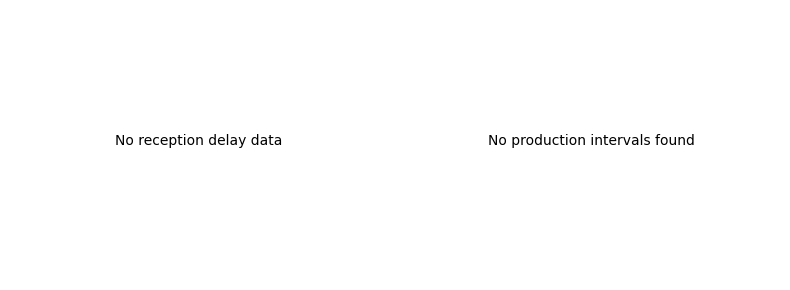

In [9]:
# Time elapsed between blocks (histogram) — aggregate from `loaded_data` (no csv_basename level)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker

# Helper: trim chain similar to plot_helpers.trim_chain
def trim_chain(df, levels=1):
    sub_df = df
    while levels:
        try:
            sub_df = sub_df.query('HASH in PHASH')
        except Exception:
            # if columns missing or query fails, break
            break
        levels -= 1
    return sub_df

# Verify we have loaded_data
if 'loaded_data' not in globals() or not loaded_data:
    print("No `loaded_data` found. Use the picker to Load data first.")
else:
    # Collect all block dataframes from loaded_data
    dfs = []
    missing = set()
    for exp_key, runs in loaded_data.items():
        for rep, robots in runs.items():
            for robot_int, robot_entry in robots.items():
                # robot_entry is now a DataFrame
                if isinstance(robot_entry, pd.DataFrame):
                    df_block = robot_entry.copy()
                    df_block['EXP'] = exp_key
                    df_block['REP'] = rep
                    df_block['ROBOT'] = robot_int
                    dfs.append(df_block)
                else:
                    missing.add((exp_key, rep, robot_int))

    if not dfs:
        print('No "block" CSVs found in the chosen data. Make sure you selected the CSV kind you wanted in the picker for the experiments.')
    else:
        df = pd.concat(dfs, ignore_index=True)

        # Ensure numeric columns
        df['TELAPSED'] = pd.to_numeric(df.get('TELAPSED', pd.Series(dtype=float)), errors='coerce')
        df['TIMESTAMP'] = pd.to_numeric(df.get('TIMESTAMP', pd.Series(dtype=float)), errors='coerce')

        # Plot configuration
        XMAX = 15
        bins = range(0, XMAX+1, 1)
        fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,3))

        # LEFT: Reception delay (TELAPSED)
        tel = df['TELAPSED'].dropna()
        if len(tel) == 0:
            ax[0].text(0.5, 0.5, 'No reception delay data', ha='center')
            ax[0].set_axis_off()
        else:
            hist, bins_arr = np.histogram(tel, bins=bins)
            denom = hist.sum()
            if denom > 0:
                cum = np.cumsum(hist.astype(np.float32)) / denom
            else:
                cum = np.zeros_like(hist, dtype=float)
            ax[0].bar(bins_arr[:-1]+(bins_arr[1]-bins_arr[0])/2,
                      cum,
                      width =(bins_arr[1]-bins_arr[0]),
                      color ='green',
                      alpha = 0.6,
                      zorder= 3)
            ax[0].grid(axis='x', linestyle='--', color='k', zorder=1)
            ax[0].text(XMAX-0.8,0.2,'n=%s blocks' % format(len(tel), ',d'),ha='right',zorder=4)
            t = ax[0].text(XMAX-0.8,0.2,'n=%s blocks' % format(len(tel), ',d'),ha='right',color='white',zorder=2)
            t.set_bbox(dict(facecolor='white', edgecolor='white'))
            ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
            ax[0].set_ylim(ymin=0, ymax = 1)
            ax[0].set_xticks(bins)
            ax[0].set_xlim(xmin=bins[0], xmax = bins[-1])
            ax[0].set_xlabel('Block Reception Delay  [s]')

        # RIGHT: Production delay (TPROD)
        df_unique = df.drop_duplicates('HASH') if 'HASH' in df.columns else df
        df_trimmed = trim_chain(df_unique, 10).sort_values('TIMESTAMP')
        if 'EXP' in df_trimmed.columns and 'REP' in df_trimmed.columns and 'TIMESTAMP' in df_trimmed.columns:
            df_trimmed['TPROD'] = df_trimmed.groupby(['EXP', 'REP'])['TIMESTAMP'].diff(1)
            tprod = df_trimmed['TPROD'].dropna()
            if len(tprod) == 0:
                ax[1].text(0.5, 0.5, 'No production intervals found', ha='center')
                ax[1].set_axis_off()
            else:
                hist, bins_arr = np.histogram(tprod, bins=bins)
                denom = hist.sum()
                if denom > 0:
                    cum = np.cumsum(hist.astype(np.float32)) / denom
                else:
                    cum = np.zeros_like(hist, dtype=float)
                ax[1].bar(bins_arr[:-1]+(bins_arr[1]-bins_arr[0])/2,
                          cum,
                          width =(bins_arr[1]-bins_arr[0]),
                          color ='green',
                          alpha = 0.6,
                          zorder=3)
                ax[1].grid(axis='x', linestyle='--', color='k',zorder=1)
                ax[1].text(XMAX-0.8,0.2,'n=%s unique blocks' % format(len(df_trimmed), ',d'),ha='right',zorder=4)
                t = ax[1].text(XMAX-0.8,0.2,'n=%s unique blocks' % format(len(df_trimmed), ',d'),ha='right',color='white',zorder=2)
                t.set_bbox(dict(facecolor='white', edgecolor='white'))
                ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
                ax[1].set_ylim(ymin=0, ymax = 1)
                ax[1].set_xticks(bins)
                ax[1].set_xlim(xmin=bins[0], xmax = bins[-1])
                ax[1].set_xlabel('Block Production Delay  [s]')
        else:
            ax[1].text(0.5, 0.5, 'Insufficient data for production delay', ha='center')
            ax[1].set_axis_off()

        fig.tight_layout()
        plt.show()